# Speaker Identification using Classical Machine Learning

In this notebook, we classify speakers using audio samples. We extract MFCC features and use classical ML models such as:
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Logistic Regression (LR)
- Random Forest (RF)
- Ensemble models: Voting & Stacking

Dataset: Mozilla Common Voice (subset)
Features: MFCC (13 coefficients)


## 1. Setup and Imports
We import the necessary libraries for audio processing, feature extraction, model training, and evaluation.

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier

## 2. Load and Label Audio Data

We use the Mozilla Common Voice dataset. All audio `.wav` files are located in the `clips/` directory. Each audio clip is linked to a speaker via the `client_id` field in `validated.tsv`.

Steps:
- Load metadata (`validated.tsv`)
- Select a subset of speakers (e.g., top 10 with the most recordings)
- Extract MFCCs from each clip and label using `client_id`


data/
└── cv-corpus-21.0-delta-2025-03-14-en
    └── cv-corpus-21.0-delta-2025-03-14
        └── en
            ├── clip_durations.tsv
            ├── clips                                                        <-- all audio .mp3 files here
            │   └── common_voice_en_41980499.mp3                             <-- metadata including speaker_id                    
            ├── invalidated.tsv
            ├── other.tsv
            ├── reported.tsv
            ├── unvalidated_sentences.tsv
            ├── validated_sentences.tsv
            └── validated.tsv

In [4]:

# --- New dataset path ---
base_dir = "../data/cv-corpus-16.1-delta-2023-12-06-en/cv-corpus-16.1-delta-2023-12-06/en"
clips_dir = os.path.join(base_dir, "clips")
metadata_file = os.path.join(base_dir, "validated.tsv")

# --- Load metadata ---
df = pd.read_csv(metadata_file, sep="\t")
df = df[['path', 'client_id']]  # Keep only necessary columns

# --- Filter all speakers with at least MIN_CLIPS ---
MIN_CLIPS_PER_SPEAKER = 10

speaker_counts = df['client_id'].value_counts()
eligible_speakers = speaker_counts[speaker_counts >= MIN_CLIPS_PER_SPEAKER].index

df = df[df['client_id'].isin(eligible_speakers)]
df = df.groupby('client_id').head(MIN_CLIPS_PER_SPEAKER)

print(f"Selected {df['client_id'].nunique()} speakers")
print(f"Total clips: {len(df)}")

# --- Feature extraction ---
def extract_features(file_path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    delta = np.mean(librosa.feature.delta(mfcc), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    return np.concatenate([mfcc_mean, delta, chroma, contrast])

# --- Process all samples ---
X, y = [], []

for _, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(clips_dir, row['path'])
    try:
        features = extract_features(file_path)
        X.append(features)
        y.append(row['client_id'])
    except Exception as e:
        print(f"Error with {file_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"\nFeature matrix: {X.shape}")
print(f"Labels: {y.shape}")

# --- Save to .npz ---
output_dir = "../audios/"
save_path = os.path.join(output_dir, "processed_dataset.npz")
np.savez_compressed(save_path, X=X, y=y)
print("Saved dataset to processed_data.npz")


Selected 41 speakers
Total clips: 410


100%|██████████| 410/410 [01:12<00:00,  5.64it/s]


Feature matrix: (410, 45)
Labels: (410,)
Saved dataset to processed_data.npz


In [32]:
# --- Describe extracted features ---
print("\n📊 Extracted Features Summary:")
print("- MFCCs (mean):             13 coefficients")
print("- Delta MFCCs (mean):       13 coefficients")
print("- Chroma STFT (mean):       12 coefficients")
print("- Spectral Contrast (mean): 7 coefficients")
print(f"Total features per sample: {X.shape[1]} features")



📊 Extracted Features Summary:
- MFCCs (mean):             13 coefficients
- Delta MFCCs (mean):       13 coefficients
- Chroma STFT (mean):       12 coefficients
- Spectral Contrast (mean): 7 coefficients
Total features per sample: 45 features


In [18]:
import numpy as np

data = np.load("../audios/processed_dataset.npz")
X = data['X']
y = data['y']


In [19]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Number of unique speakers:", len(np.unique(y)))
print("Feature dimension per sample:", X.shape[1] if len(X.shape) > 1 else "Invalid")


X shape: (410, 45)
y shape: (410,)
Number of unique speakers: 41
Feature dimension per sample: 45


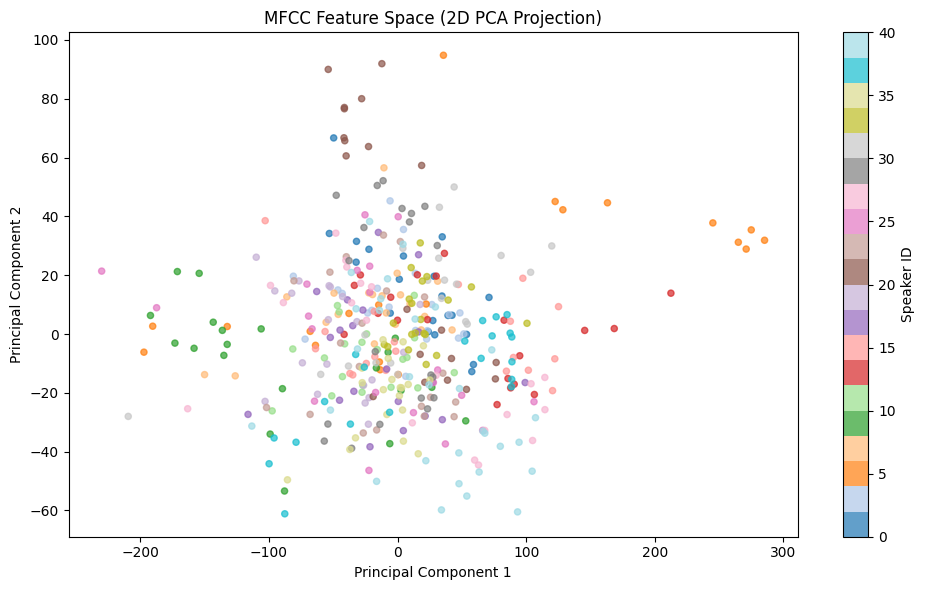

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce MFCC features to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Plot with colors by speaker
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pd.factorize(y)[0], cmap='tab20', s=20, alpha=0.7)

plt.title("MFCC Feature Space (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Speaker ID")
plt.tight_layout()
plt.show()


In [25]:
# Load the TSV metadata
tsv_path = "../data/cv-corpus-16.1-delta-2023-12-06-en/cv-corpus-16.1-delta-2023-12-06/en/validated.tsv"
df = pd.read_csv(tsv_path, sep='\t')

In [26]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Load metadata
df_full = pd.read_csv(tsv_path, sep='\t')
df_full = df_full[['client_id', 'gender', 'age']].dropna()

# 2. Build feature DataFrame
df_features = pd.DataFrame(X, columns=[f'mfcc_{i}' for i in range(X.shape[1])])
df_features['client_id'] = y

# 3. Merge on client_id
df_plot = pd.merge(df_features, df_full, on='client_id', how='inner')

# 4. Drop rows with missing gender or age (optional: keep only usable samples)
df_plot_filtered = df_plot.dropna(subset=['gender', 'age']).copy()

# 5. Apply PCA on the MFCCs
mfcc_cols = [f'mfcc_{i}' for i in range(13)]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_plot_filtered[mfcc_cols].values)

df_plot_filtered['PC1'] = X_pca[:, 0]
df_plot_filtered['PC2'] = X_pca[:, 1]


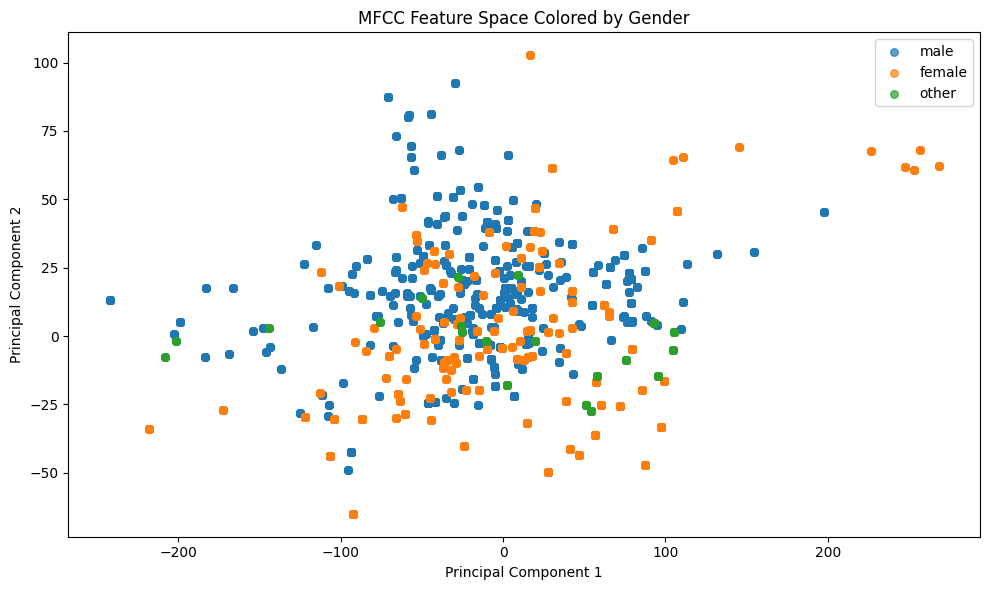

In [27]:
plt.figure(figsize=(10, 6))
for gender in df_plot_filtered['gender'].unique():
    subset = df_plot_filtered[df_plot_filtered['gender'] == gender]
    plt.scatter(subset['PC1'], subset['PC2'], label=gender, alpha=0.7, s=30)

plt.title("MFCC Feature Space Colored by Gender")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()


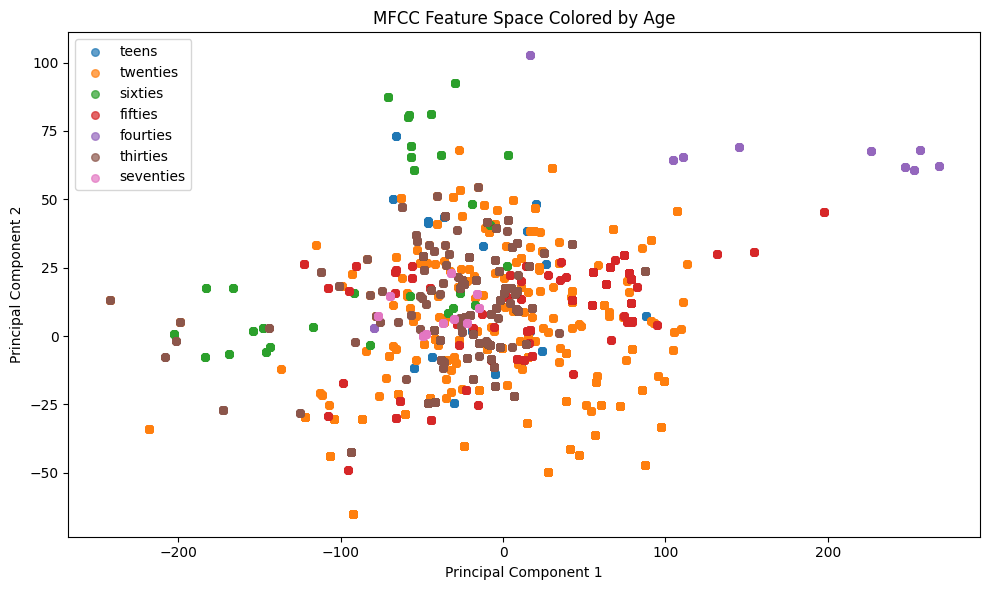

In [28]:
plt.figure(figsize=(10, 6))
for age in df_plot_filtered['age'].unique():
    subset = df_plot_filtered[df_plot_filtered['age'] == age]
    plt.scatter(subset['PC1'], subset['PC2'], label=age, alpha=0.7, s=30)

plt.title("MFCC Feature Space Colored by Age")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()


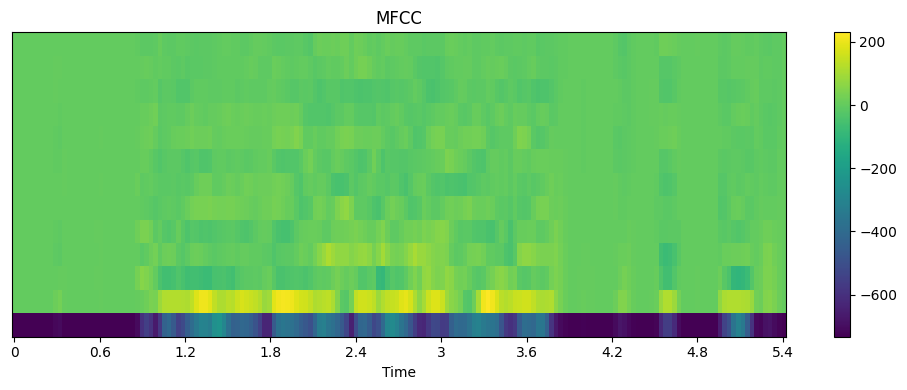

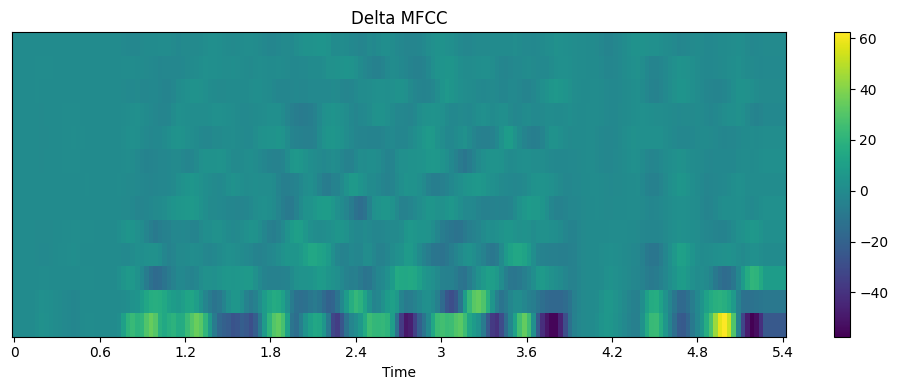

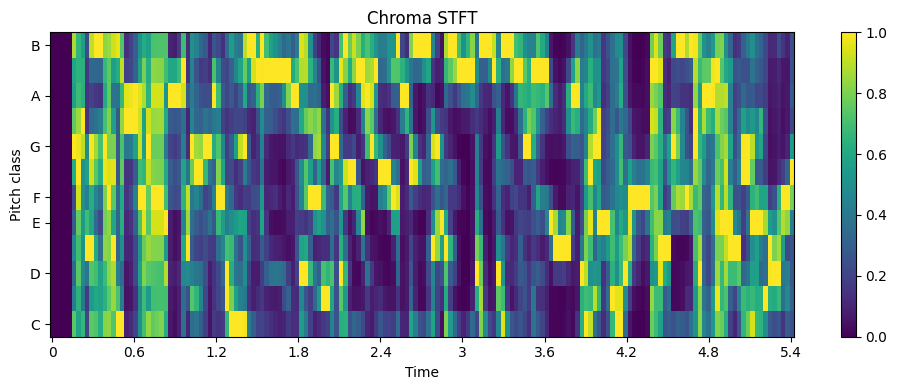

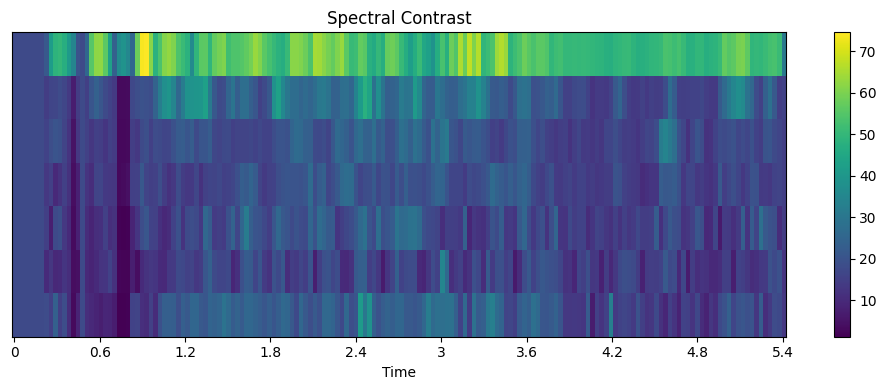

In [31]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

# --- Load one audio file ---
audio_path =  "../data/cv-corpus-16.1-delta-2023-12-06-en/cv-corpus-16.1-delta-2023-12-06/en/clips/common_voice_en_38487408.mp3" # adjust if needed
y, sr = librosa.load(audio_path, sr=16000)

# --- Extract full features ---
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
delta = librosa.feature.delta(mfcc)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# --- Set output folder ---
output_folder = "visualizations"
os.makedirs(output_folder, exist_ok=True)

# --- Save MFCC ---
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "mfcc_visualization.png"))
plt.show()

# --- Save Delta MFCC ---
plt.figure(figsize=(10, 4))
librosa.display.specshow(delta, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("Delta MFCC")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "delta_mfcc_visualization.png"))
plt.show()

# --- Save Chroma STFT ---
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("Chroma STFT")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "chroma_visualization.png"))
plt.show()

# --- Save Spectral Contrast ---
plt.figure(figsize=(10, 4))
librosa.display.specshow(contrast, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("Spectral Contrast")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "spectral_contrast_visualization.png"))
plt.show()


## 3. Prepare the Dataset: Encode, Scale, and Split

Before training, we need to preprocess the dataset:

1. **Load the `.npz` file**:
   - This file contains `X` (feature vectors) and `y` (speaker labels).

2. **Encode speaker labels**:
   - Since machine learning models require numeric class labels, we convert speaker IDs (e.g., `c002dfbc...`) to integers (e.g., `0`, `1`, `2`, ...).

3. **Scale the features**:
   - Our features include MFCC, chroma, and spectral contrast, which have different value ranges.
   - We use `StandardScaler` to normalize the features so they all have the same scale (mean = 0, std = 1). This improves model performance, especially for distance-based algorithms like KNN and SVM.

4. **Split the dataset**:
   - We use an 80/20 train-test split with stratification to ensure each speaker is equally represented in both sets.


In [15]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import os

# --- Load the saved .npz file ---
data = np.load("../audios/processed_dataset.npz")
X = data['X']
y = data['y']

print(f"Loaded X shape: {X.shape}")
print(f"Loaded y shape: {y.shape}")

# --- Encode speaker labels to integers ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Split into train and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

# --- Create directory if needed ---
output_dir = "../audios/splits"
os.makedirs(output_dir, exist_ok=True)

# --- Save splits ---
np.savez_compressed(os.path.join(output_dir, "train.npz"), X=X_train, y=y_train)
np.savez_compressed(os.path.join(output_dir, "test.npz"), X=X_test, y=y_test)

print("Saved training set to train.npz")
print("Saved test set to test.npz")


Loaded X shape: (410, 45)
Loaded y shape: (410,)
Training set: (328, 45), Labels: (328,)
Test set: (82, 45), Labels: (82,)
Saved training set to train.npz
Saved test set to test.npz


## Visualizing Feature Space Before and After Scaling

We use PCA to project the high-dimensional feature vectors down to 2D, so we can visualize them.

- The left plot shows the features **before scaling**.
- The right plot shows the features **after scaling** with `StandardScaler`.

Scaling standardizes the feature ranges, making the dataset more balanced and improving model performance — especially for algorithms that rely on distance (like KNN and SVM).


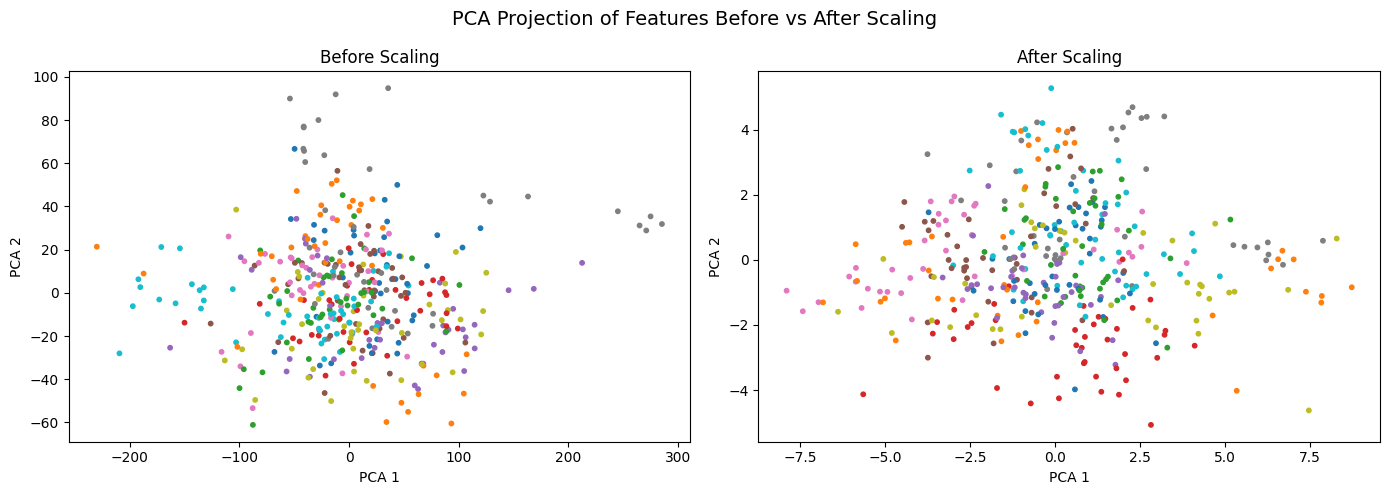

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensions for plotting
pca = PCA(n_components=2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Before scaling
X_pca_raw = pca.fit_transform(X)

# After scaling
X_pca_scaled = pca.fit_transform(X_scaled)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw features
axes[0].scatter(X_pca_raw[:, 0], X_pca_raw[:, 1], c=y_encoded, cmap='tab10', s=10)
axes[0].set_title("Before Scaling")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

# Scaled features
axes[1].scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=y_encoded, cmap='tab10', s=10)
axes[1].set_title("After Scaling")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")

plt.suptitle("PCA Projection of Features Before vs After Scaling", fontsize=14)
plt.tight_layout()
plt.show()


## 🔹 K-Nearest Neighbors (KNN)

KNN is a simple, non-parametric classification algorithm.

- It works by **finding the k closest samples** in the training data to a test sample, using a distance metric (usually Euclidean).
- It assigns the label by **majority vote** among those neighbors.

KNN is sensitive to feature scale (why we scaled earlier) and works well with balanced datasets.


In [24]:
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Initialize KNN with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model on training data
knn.fit(X_train, y_train)

print("KNN model has been trained.")

# Save the trained KNN model
joblib.dump(knn, "../models/knn_model.joblib")
print("KNN model has been saved to models/knn_model.joblib.")


KNN model has been trained.
KNN model has been saved to models/knn_model.joblib.


## 🔹 Support Vector Machine (SVM)

SVM is a powerful classifier that tries to **maximize the margin** between classes.

- It finds a **hyperplane** that best separates the classes in high-dimensional space.
- Works well for both linear and non-linear data.
- Sensitive to scale and works great with a small number of samples per class.

We'll use a linear kernel to start with.


In [25]:
from sklearn.svm import SVC

# Initialize SVM with linear kernel
svm = SVC(kernel='linear', probability=True)

# Fit the model on training data
svm.fit(X_train, y_train)

print("SVM model has been trained.")

# Save the trained SVM model
joblib.dump(svm, "../models/svm_model.joblib")
print("SVM model has been saved to models/svm_model.joblib.")

SVM model has been trained.
SVM model has been saved to models/svm_model.joblib.


## 🔹 Logistic Regression

Logistic Regression is a linear model used for classification.

- It models the **probability** that a sample belongs to a class using the logistic (sigmoid) function.
- It's simple, efficient, and interpretable.
- Performs well when classes are linearly separable or almost so.


In [27]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression
lr = LogisticRegression(max_iter=1000)

# Fit the model on training data
lr.fit(X_train, y_train)

print("Logistic Regression model has been trained.")

# Save the trained logistic regression model
joblib.dump(lr, "../models/logistic_regression_model.joblib")
print("Logistic Regression model has been saved to models/logistic_regression_model.joblib.")


Logistic Regression model has been trained.
Logistic Regression model has been saved to models/logistic_regression_model.joblib.


## 🔹 Random Forest Classifier

Random Forest is an **ensemble method** made up of many decision trees.

- Each tree is trained on a random subset of the data and features.
- The final prediction is made by **majority voting** across all trees.
- It can handle non-linear relationships and is robust to noise.

It works well out of the box for many datasets.


In [28]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on training data
rf.fit(X_train, y_train)

print("Random Forest model has been trained.")

# Save the trained logistic regression model
joblib.dump(lr, "../models/random_forest_model.joblib")
print("Random Forest model has been saved to models/random_forest_model.joblib.")


Random Forest model has been trained.
Random Forest model has been saved to models/random_forest_model.joblib.


## 🧪 Model Evaluation: Predictions and Performance

Now that all models are trained, it's time to evaluate how well they perform on unseen test data.

For each model, we will:
1. Use `.predict(X_test)` to get predicted labels.
2. Compare predictions with the true labels `y_test`.
3. Measure performance using:
   - **Accuracy score**
   - **Classification report** (precision, recall, F1-score)
   - **Confusion matrix** to visualize predictions per class


## Model Evaluation: Predictions and Performance

Now that all models have been trained, it is time to evaluate how well they perform on unseen test data.

For each model, we will:
1. Use `.predict(X_test)` to generate predicted labels.
2. Compare these predictions to the true labels (`y_test`).
3. Measure performance using the following metrics:
   - **Classification Accuracy**: The overall percentage of correct predictions.
   - **Classification Report**: Includes precision, recall, and F1-score per class.
   - **Confusion Matrix**: A visual breakdown showing which speakers were predicted correctly and which were confused.

---

## Evaluation Strategy (Project Specification)

To align with the evaluation methodology described in the project specification, we apply:

- **Classification Accuracy**  
  Quantifies the overall correctness of model predictions.

- **Confusion Matrix**  
  Helps us identify which speakers are being misclassified and how often.

- **5-Fold Cross-Validation**  
  Increases the reliability of model performance estimates by testing the model on multiple different subsets of the data.  
  This reduces the likelihood of misleading results from a single train-test split.



 Evaluating KNN
Test Accuracy: 0.8415
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       0.67      1.00      0.80         2
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2
          15       0.67      1.00      0.80         2
          16       

/home/ahmed-bashir/Documents/school/VoiceScope/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ahmed-bashir/Documents/school/VoiceScope/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ahmed-bashir/Documents/school/VoiceScope/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

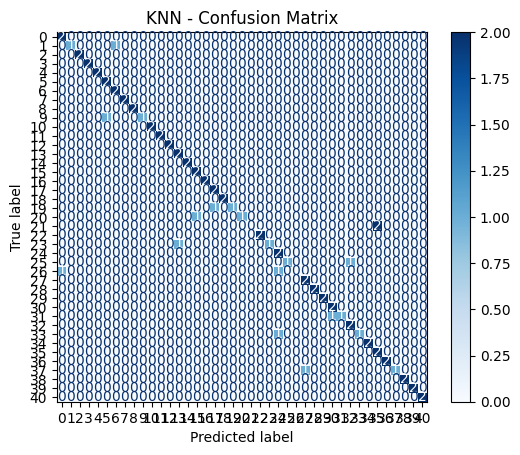

5-Fold CV Accuracy: 0.8610 ± 0.0467

 Evaluating SVM
Test Accuracy: 0.9146
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00    

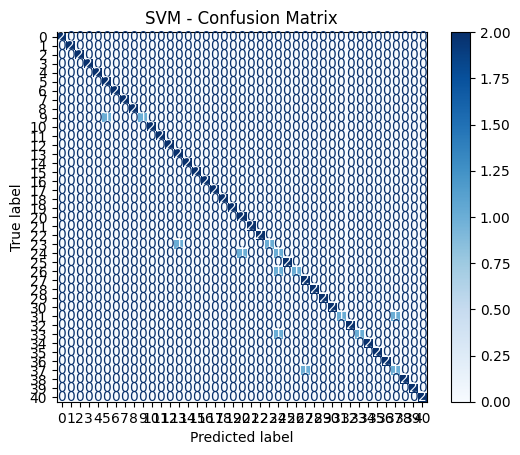

5-Fold CV Accuracy: 0.9439 ± 0.0274

 Evaluating Logistic Regression
Test Accuracy: 0.9634
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.

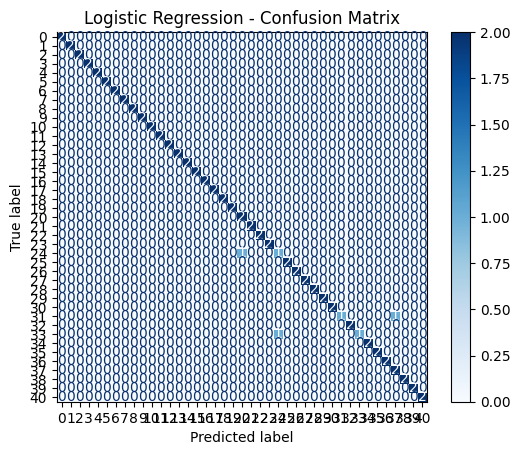

5-Fold CV Accuracy: 0.9390 ± 0.0336

 Evaluating Random Forest
Test Accuracy: 0.9634
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00    

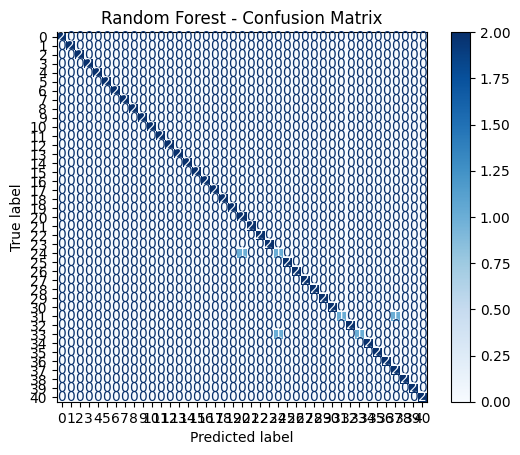

5-Fold CV Accuracy: 0.9390 ± 0.0336


In [32]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# --- Load models ---
knn = joblib.load("../models/knn_model.joblib")
svm = joblib.load("../models/svm_model.joblib")
lr = joblib.load("../models/logistic_regression_model.joblib")
rf = joblib.load("../models/random_forest_model.joblib")

models = {
    "KNN": knn,
    "SVM": svm,
    "Logistic Regression": lr,
    "Random Forest": rf
}

# --- Evaluate ---
for name, model in models.items():
    print(f"\n Evaluating {name}")

    # Predict
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Optional: 5-Fold Cross-Validation
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=5)
    print(f"5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
